# Preprocessing Use of Force Data
This notebook is designed to show the preprocessing of use of force data in preparation for modelling civilian injury. The data is not yet publicly available and as such, the data file cannot be provided in the supporting materials. Due to confidentiality reasons, only aggregated statistics will be displayed and no rows of the dataframe will be shown. 
## Steps Overview:
1. Load use of force data from 2004-2020 (obtained from CPD under FOIA requests)
2. Check missing values and avaliable variables
3. Drop columns with high missing values and no contribution to the analysis
4. Clean missing values in variables of interest
5. Recode person, resistance type and action
6. Deduplicate the dataset by uid_force and uid
7. Recode rank
8. Clean beats and derive police district numbers
9. Derive years and months of experience (officer)
10. Export preprocessed dataset

In [5]:
import pandas as pd
import matplotlib
import re
import sys
print("Python version:", sys.version)
# Print versions of each package
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)

Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Pandas version: 2.0.3
Matplotlib version: 3.7.2


In [6]:
import matplotlib.pyplot as plt

In [8]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

## Step 1: Load use of force data from 2004-2020 (obtained from CPD under FOIA requests)

In [12]:
# Step 1: Load the dataset
force = pd.read_parquet("force.parquet")


## Step 2: Check missing values and available variables
Dataset needs to be deduplicated by uid, dt and uid_force->actual inidivudal use of force instances are much less than the whole dataset size

In [14]:
missing_val_original = force.isna().sum()
print(missing_val_original)

uid_force                          0
rd                                97
cr                            604640
cb                             41486
event                           1623
beat                               0
block                              0
street_direction                 561
street                             0
location                           0
outdoor                        36914
lighting_condition             27223
weather_condition              30256
notify_oemc                   531692
notify_district_sergeant      516258
notify_operational_command    628042
notify_detective_division     642407
weapons_discharged            554358
party_fired_first             599574
gender                             0
race                               0
appointed                       1395
assigned_unit                      0
assigned_unit_detail          576424
assigned_beat                  13262
rank                              11
duty_status                      481
o

## Step 3: Drop columns with high missing values and no contribution to the analysis
1. 'rd', 'cr', 'cb', 'event', 'ir' - internal report referencing numbers and identifiers, which are redundant due to the unique identifier 'uid_force"
2. 'notify_' columns - binary indicators of whether administrative reports need to be filed to different branches of the reporting system - they are designed for internal monitoring and as such are not contributive to the analysis
3. 'block', 'street_direction', 'street' - georaphical information that is too granular and is already captured by 'beat'
4. 'outdoor' - duplicated variable with missing values, 'inside' already provides that information
5. 'lighting_condition', 'weather_condition', 'location' - provide high granularity and are unlikely to be singificant predictors
6. 'asigned_unit_detail' - high percentage of missing values
7. 'assigned_unit', 'assigned_beat' - values of no predictive power, beat is already present and assigned units are used for internal reference, rank would be more suitable for modelling
8. 'civilian_age'- problematic missing values, which might be due to error calculations from 'civillian_yob' 
9. 'current_rank', 'current_unit', 'current_beat' - not the focus of the analysis
10. 'report_created", 'policy_compliance' - high number of missing values suggesting data quality issues, should be dropped
11. 'aid' -  shift identifier which is unavailable for data before 2014, column should be dropped
12. 'description' - text variable containing additional description of actions, referring both to member and civilian actions. Unnecessary as person, action and resistance type already capture the key information.
13. 'officer_injured' - not outcome of interest and would not make sense to be used in a model of civilian injury
14. 'civilian_alleged_injury' - not outcome of interest, would necessitate additional analysis beyond the scope of this project

In [16]:
#Drop columns
columns_to_drop = [
    'rd', 'cr', 'cb', 'event', 'block', 'street_direction', 'street', 
    'location', 'lighting_condition', 'weather_condition', 'description', 
    'outdoor', 'notify_oemc', 'notify_district_sergeant', 'notify_operational_command', 
    'notify_detective_division', 'assigned_unit_detail', 'assigned_unit', 'officer_injured',
    'assigned_beat', 'ir', 'civilian_age', 'current_rank', 'current_unit', 'current_beat', 
    'report_created', 'policy_compliance', 'strict', 'aid', 'civilian_alleged_injury'
]
force_clean = force.drop(columns=columns_to_drop)

## Step 4: Clean missing values in variables of interest
Dataset needs to be deduplicated by uid, dt and uid_force->actual inidivudal use of force instances are much less than the whole dataset size. Imputation would not be a suitable strategy for the key predictors as it can introduce bias which might affect the analysis and modelling procedures. 

In [18]:
# Missing uid rows need to be dropped, as the dataframe cannot be deduplicated successfully otherwise
force_clean = force_clean.dropna(subset=['uid'])

In [20]:
# Check the shape of the dataset
print("Dataset shape:", force_clean.shape)

Dataset shape: (647406, 21)


In [21]:
missing_val = force_clean.isna().sum()
print(missing_val)

uid_force                  0
beat                       0
weapons_discharged    551180
party_fired_first     596289
gender                     0
race                       0
appointed                  0
rank                      11
duty_status              474
in_uniform               513
civilian_gender          590
civilian_race           5905
civilian_yob               0
civilian_armed           569
civilian_injured        8026
dt                         0
person                    38
resistance_type           38
action                    38
uid                        0
inside                     0
dtype: int64


In [22]:
# Drop missing values in 'civilian_gender', 'rank', 'civilian_race', 'civilian_injured'(outcome), 'person', 'resistance_type', 'action' - these are key variables for the analysis
force_clean = force_clean.dropna(subset=['civilian_gender'])
force_clean = force_clean.dropna(subset=['rank'])
force_clean = force_clean.dropna(subset=['civilian_race'])
force_clean = force_clean.dropna(subset=['civilian_injured'])
force_clean = force_clean.dropna(subset=['person'])
force_clean = force_clean.dropna(subset=['resistance_type'])
force_clean = force_clean.dropna(subset=['action'])

In [25]:
# Check the shape of the dataset
missing_val = force_clean.isna().sum()
print(missing_val)

uid_force                  0
beat                       0
weapons_discharged    537834
party_fired_first     582348
gender                     0
race                       0
appointed                  0
rank                       0
duty_status              443
in_uniform               475
civilian_gender            0
civilian_race              0
civilian_yob               0
civilian_armed           200
civilian_injured           0
dt                         0
person                     0
resistance_type            0
action                     0
uid                        0
inside                     0
dtype: int64


In [26]:
#Assuming that if weapons_discharged is NA, then no weapons were discharged as there would have been record of it, which would be the most logical explanation given the huge percentage of 'NA'
force_clean['weapons_discharged'].fillna(0, inplace=True)

In [29]:
# Filling 'party_fired_first' with 'NONE FIRED' where 'weapons_discharged' is 0, otherwise drop missing values as they can bias the results 
force_clean.loc[force_clean['weapons_discharged'] == 0, 'party_fired_first'] = 'NONE FIRED'
# Drop  rows where 'party_fired_first' is still NaN
force_clean = force_clean.dropna(subset=['party_fired_first'])

In [31]:
#Assuming that if there is no record of civilian_armed=False
force_clean['civilian_armed'].fillna(False, inplace=True)

In [32]:
#Filling missing values with the mode as there are very few instances (likely concentrated in the same few use of force accidents, as the data has not been deduplicated yet)
force_clean['in_uniform'].fillna(force_clean['in_uniform'].mode()[0], inplace=True)

In [33]:
#Calculate age based on civilian birth as the orignial variable clearly contains data entry errors - impose a plausible range 
force_clean['civilian_yob'] = force_clean['civilian_yob'].apply(lambda x: x if 1924 <= x <= 2002 else None)

# Step 6: Calculate 'civilian_age' from 'civilian_yob' and event 'dt'
force_clean['civilian_age'] = force_clean.apply(lambda row: row['dt'].year - row['civilian_yob'] if pd.notna(row['civilian_yob']) and pd.notna(row['dt']) else None, axis=1)


In [35]:
#Drop invalid entries in age, yob and duty status
force_clean = force_clean.dropna(subset=['civilian_age', 'civilian_yob', 'duty_status'])

In [37]:
#Recode civilian race - some values not NA but still missing
race_mapping = {
    'BLACK': 'Black', 'WHITE': 'White', 'ASIAN/PACIFIC ISLANDER': 'Asian', 
    'ASIAN / PACIFIC ISLANDER': 'Asian', 'BLACK HISPANIC': 'Black', 
    'WHITE HISPANIC': 'Hispanic', 'AMER IND/ALASKAN NATIVE': 'Native American',
    'AMER INDIAN / ALASKAN NATIVE': 'Native American', 'SPANISH (DO NOT USE)': 'Hispanic','UNKNOWN': None,  
    'UNKNOWN / REFUSED': None 
}
force_clean['civilian_race'] = force_clean['civilian_race'].replace(race_mapping)

# Drop rows
force_clean = force_clean.dropna(subset=['civilian_race'])


In [39]:
# Recode officer race
force_clean['race'] = force_clean['race'].replace({
    'BLACK': 'Black', 
    'WHITE': 'White',
    'ASIAN/PACIFIC ISLANDER': 'Asian',
    'BLACK HISPANIC': 'Black',
    'WHITE HISPANIC': 'Hispanic',
    'AMER IND/ALASKAN NATIVE': 'Native American',
    'UNKNOWN': None,  
})

# Drop NA 
force_clean = force_clean.dropna(subset=['race'])

In [43]:
#Dataset doesn't have any left missing values (coded as NA)
missing_val_original = force_clean.isna().sum()
print(missing_val_original)

uid_force             0
beat                  0
weapons_discharged    0
party_fired_first     0
gender                0
race                  0
appointed             0
rank                  0
duty_status           0
in_uniform            0
civilian_gender       0
civilian_race         0
civilian_yob          0
civilian_armed        0
civilian_injured      0
dt                    0
person                0
resistance_type       0
action                0
uid                   0
inside                0
civilian_age          0
dtype: int64


## Step 5: Recode action, person, and resistance_type
As these variables cause multiple entries reflecting sequences of actions by different people per use of force incident, they need to be concatenated in a way which will allow unique ones to be kept and then filtered by the most severe in the sequence. For example, many cases might have passive resister in the first entry but as different member actions escalate, the civilian might end up using assault against an officer, and vice versa.
Subject actions fall into  theresistance_type categories below and will be used as such for modelling.

In [45]:
#  Define severity rankings for resistance (subject) and member actions
resistance_ranking = {
    'Assailant Deadly Force': 5,
    'Assailant Assault/Battery': 4,
    'Assailant Battery': 3,
    'Active Resister': 2,
    'Passive Resister': 1
}

# Define severity ranking for member actions
member_action_ranking = {
    'Firearm': 6,
    'Impact Weapon': 5,
    'Less-Lethal Weapon': 4,
    'Physical Force (High-Impact)': 3,
    'Physical Force (Low-Impact)': 2,
    'Control Methods': 1,
    'Verbal Commands': 0,
    'Emergency Control Methods': 2,
    'Other (Specify)': 2,
}

# Recode the member actions into severity categories
def recode_member_action(action):
    if action == 'FIREARM':
        return 'Firearm'
    elif 'IMPACT WEAPON' in action or 'IMPACT MUNITION' in action:
        return 'Impact Weapon'
    elif 'TASER' in action or 'O.C./CHEMICAL WEAPON' in action or action == 'CANINE':
        return 'Less-Lethal Weapon'
    elif action == 'CLOSED HAND STRIKE/PUNCH' or action == 'KNEE STRIKE' or action == 'KICKS':
        return 'Physical Force (High-Impact)'
    elif action == 'ESCORT HOLDS' or action == 'WRISTLOCK' or action == 'MEMBER PRESENCE':
        return 'Control Methods'
    elif action == 'VERBAL COMMANDS':
        return 'Verbal Commands'
    elif action == 'TAKE DOWN/EMERGENCY HANDCUFFING':
        return 'Emergency Control Methods'
    elif action == 'ARMBAR' or action == 'OPEN HAND STRIKE' or action == 'ELBOW STRIKE' or action == 'PRESSURE SENSITIVE AREAS':
        return 'Physical Force (Low-Impact)'
    else:
        return 'Unknown'

In [46]:
# Combine actions and resistance type for each group
def process_group(group):
    # Process Subject Action (resistance)
    subject_resistances = group[group['person'] == 'Subject Action']['resistance_type'].values
    if len(subject_resistances) > 0:
        highest_resistance = max(subject_resistances, key=lambda x: resistance_ranking.get(x.strip(), 0))
    else:
        highest_resistance = None

    # Process Member Action
    member_actions = group[group['person'] == 'Member Action']['action'].apply(recode_member_action).values
    if len(member_actions) > 0:
        highest_member_action = max(member_actions, key=lambda x: member_action_ranking.get(x.strip(), 0))
    else:
        highest_member_action = None

    # Concatenate actions
    subject_actions = group[group['person'] == 'Subject Action']['action'].unique()
    member_actions_with_descriptions = group[group['person'] == 'Member Action']['action'].unique()

    return pd.Series({
        'subject_resistance': highest_resistance,
        'member_action_severity': highest_member_action,
        'concatenated_subject_actions': ', '.join(subject_actions),
        'concatenated_member_actions': ', '.join(member_actions_with_descriptions)
    })

## Step 6: Deduplicate the dataset by uid_force and uid
In order to get one row per officer per incident (as multiple officers might have participated, with varying extents of involvement). Moreover, the highest 'ranking' of force and member action will be preserved in the deduplicated data frame.

In [48]:
# Apply the processing in one step and deduplicate the dataset
deduplicated = force_clean.groupby(['uid_force', 'uid']).apply(process_group).reset_index()


In [49]:
# Merge the results back into the main dataset and drop duplicate columns
force_deduplicated = force_clean.drop(columns=['person', 'action', 'resistance_type']).drop_duplicates(['uid_force', 'uid'])
force_deduplicated = force_deduplicated.merge(deduplicated, on=['uid_force', 'uid'], how='left')

In [50]:
# Drop rows where concatenated subject or member actions are missing
force_deduplicated_cleaned = force_deduplicated.dropna(subset=['subject_resistance', 'member_action_severity'])

# Verify that missing rows are dropped
missing_val_after_drop = force_deduplicated_cleaned.isna().sum()


In [51]:
missing_val_original = force_deduplicated_cleaned.isna().sum()
print(missing_val_original)

uid_force                       0
beat                            0
weapons_discharged              0
party_fired_first               0
gender                          0
race                            0
appointed                       0
rank                            0
duty_status                     0
in_uniform                      0
civilian_gender                 0
civilian_race                   0
civilian_yob                    0
civilian_armed                  0
civilian_injured                0
dt                              0
uid                             0
inside                          0
civilian_age                    0
subject_resistance              0
member_action_severity          0
concatenated_subject_actions    0
concatenated_member_actions     0
dtype: int64


In [52]:
# Check the shape of the cleaned dataset to ensure rows were dropped
print("Final dataset shape:", force_deduplicated_cleaned.shape)

Final dataset shape: (77353, 23)


In [53]:
# Check unique values in all columns
unique_values = force_deduplicated_cleaned.nunique()

# Display the number of unique values in each column
print(unique_values)

#Print unique values in each column - hashed due to sensitive data display
#for column in force_deduplicated_cleaned.columns:
   #print(f"Unique values for {column}:")
   #print(force_deduplicated_cleaned[column].unique())
   #print("\n")

uid_force                       76919
beat                              305
weapons_discharged                  5
party_fired_first                   4
gender                              2
race                                5
appointed                         365
rank                               42
duty_status                         2
in_uniform                          2
civilian_gender                     2
civilian_race                       5
civilian_yob                       78
civilian_armed                      2
civilian_injured                    2
dt                              52144
uid                             12892
inside                              2
civilian_age                       69
subject_resistance                  5
member_action_severity              9
concatenated_subject_actions     3544
concatenated_member_actions      9565
dtype: int64


## Step 7: Recode rank
The latest years in the data used codes instead of word abbreviations for rank, hence recoding was needed. The 4-digit numbers correspond to specific ranks within the CPD.
Furthermore, rank categories needed to be recoded for clarity.

In [55]:
# Rank unique values
unique_ranks = force_deduplicated_cleaned['rank'].unique()
print("Unique values in the rank column before cleaning:")
print(unique_ranks)

Unique values in the rank column before cleaning:
['SERGEANT OF POLICE' 'POLICE OFFICER' 'LIEUTENANT OF POLICE'
 'PO/FIELD TRNING OFF' 'CAPTAIN OF POLICE' 'PO ASSG CANINE HANDL'
 'PO AS DETECTIVE' 'EXPL TECH 1' 'DETENTION AIDE' 'PO ASSIGN YOUTH OFF'
 'PO ASGN GANG CRMS SP' 'POLICE AGENT' 'COMMANDER' 'PO/EXP DET CAN HAND'
 'PO/MARINE OFFICER' 'PO (PER ARB AWARD)' 'PO/MOUNTED PAT OFF.'
 'PO ASGN EVID. TECHNI' 'P O ASSGN SEC SPEC' 'DEP CHIEF'
 'PO ASGN LATEN F/P EX' 'ASST DEPUTY SUP' 'PO ASSGN TRAFF SPEC'
 'PO LEGAL OFF 1' 'SGT ASSGN SEC SPEC' 'PO LEGAL OFF 2' 'POL LAB TECH 4'
 'CHIEF' 'SUPT OF POLICE' 'P.O. ASSIGNED AS HELICOPTER PILOT' '9161'
 '9171' '9164' '9173' '9152' '9165' '9175' '9122' '9168' '9752' '9206'
 '9151']


In [56]:
rank_classification = {
    # Officers (General + Specialized)
    'POLICE OFFICER': 'Officer',
    'PO/FIELD TRNING OFF': 'Officer', 
    'PO ASSG CANINE HANDL': 'Officer',
    'PO ASSIGN YOUTH OFF': 'Officer',
    'PO ASGN GANG CRMS SP': 'Officer',
    'POLICE AGENT': 'Officer',
    'PO/EXP DET CAN HAND': 'Officer',
    'PO/MARINE OFFICER': 'Officer',
    'PO (PER ARB AWARD)': 'Officer',
    'PO/MOUNTED PAT OFF.': 'Officer',
    'P O ASSGN SEC SPEC': 'Officer',
    'PO ASSGN LATEN F/P EX': 'Officer',
    'PO ASSGN TRAFF SPEC': 'Officer',
    'PO LEGAL OFF 1': 'Officer',
    'PO LEGAL OFF 2': 'Officer',
    'P.O. ASSIGNED AS HELICOPTER PILOT': 'Officer',
    '9151': 'Officer', #Traffic specialist
    '9152': 'Officer',  # Canine handler 
    '9161': 'Officer',  # General Police Officer
    '9164': 'Officer',  # Field Training Officer
    '9168': 'Officer',  # Officer as marine
    
    # Detectives
    'PO AS DETECTIVE': 'Detective',
    '9165': 'Detective',
    # Sergeants
    'SERGEANT OF POLICE': 'Sergeant',
    'SGT ASSGN SEC SPEC': 'Sergeant',
    '9171': 'Sergeant',
    # Lieutenants
    'LIEUTENANT OF POLICE': 'Lieutenant',
    '9173': 'Lieutenant',
    # Captains
    'CAPTAIN OF POLICE': 'Captain',
    '9175': 'Captain',
    # Technicians
    'EXPL TECH 1': 'Technician',
    'POL LAB TECH 4': 'Technician',
    '9206': 'Technician',
    'PO ASGN EVID. TECHNI': 'Technician', 
    'PO ASGN LATEN F/P EX': 'Technician', #fingerprint technician
    # Commanders and above
    'COMMANDER': 'Commander',
    '9752': 'Commander',
    'DEP CHIEF': 'Deputy Chief',
    'ASST DEPUTY SUP': 'Assistant Deputy Superintendent',
    'CHIEF': 'Chief',
    'SUPT OF POLICE': 'Superintendent',
    # Aides
    'DETENTION AIDE': 'Aide',
    '9122': 'Aide'
}

In [57]:
force_deduplicated_cleaned['rank'] = force_deduplicated_cleaned['rank'].replace(rank_classification)


In [58]:
# Rank unique values
unique_ranks = force_deduplicated_cleaned['rank'].unique()
print("Unique values in rank:")
print(unique_ranks)

Unique values in rank:
['Sergeant' 'Officer' 'Lieutenant' 'Captain' 'Detective' 'Technician'
 'Aide' 'Commander' 'Deputy Chief' 'Assistant Deputy Superintendent'
 'Chief' 'Superintendent']


In [59]:
force_deduplicated_cleaned = force_deduplicated_cleaned.dropna(subset=['rank'])
# Check how many unique entries are present in dt after deduplication
unique_years_post_cleaning = force_deduplicated_cleaned['dt'].dt.year.unique()
print(f"Years present in the data after cleaning: {unique_years_post_cleaning}")

Years present in the data after cleaning: [2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020]


## Step 8: Clean beats and derive police district numbers
Beats should be 4 digit codes, but many observations in the dataset have less characters. The first 2 digits of every beat indicate the police district it's in. As acs and crime data are at district level, a new variable needs to be derived from 'beat'.

In [61]:
# Ensure beat codes are 4 digits by padding with leading zeros
force_deduplicated_cleaned['beat'] = force_deduplicated_cleaned['beat'].apply(lambda x: str(x).zfill(4))

# Check the unique beat codes after padding
print(force_deduplicated_cleaned['beat'].unique())

['1113' '1322' '1131' '1112' '1134' '1121' '1122' '1331' '3100' '1124'
 '1034' '1115' '1333' '2532' '1132' '1524' '1114' '1125' '1332' '1231'
 '0134' '1111' '1412' '1512' '1531' '1135' '1422' '1223' '1611' '1312'
 '1222' '1713' '1133' '0000' '2531' '1731' '0132' '1011' '2523' '1021'
 '1213' '1722' '1123' '1712' '1324' '2515' '1413' '1522' '1711' '1623'
 '1511' '2431' '2324' '2534' '1924' '2313' '2533' '1732' '1431' '1423'
 '2522' '2333' '2521' '0112' '1311' '1723' '0122' '1414' '2012' '1532'
 '2433' '1631' '1411' '1013' '1022' '1421' '2423' '2013' '2322' '0324'
 '0434' '0524' '0322' '0421' '1533' '1824' '1822' '2024' '0423' '2011'
 '2212' '1523' '1832' '2033' '2535' '1733' '0323' '0621' '1211' '1434'
 '2311' '2432' '0533' '1913' '0331' '2422' '0414' '2234' '0321' '0522'
 '0413' '0725' '2221' '0234' '1823' '0812' '0623' '0922' '0611' '0433'
 '1612' '0431' '0823' '0311' '0933' '0723' '1624' '0632' '0734' '0822'
 '2411' '0613' '0424' '0735' '0833' '2332' '1833' '0923' '0715' '0713'
 '0113

In [62]:
# Extract district number from the first two digits of the beat
force_deduplicated_cleaned['district'] = force_deduplicated_cleaned['beat'].str[:2]

# Check the unique district codes - 31 is not a valid district, neither is 41 or 00
print(force_deduplicated_cleaned['district'].unique())

['11' '13' '31' '10' '25' '15' '12' '01' '14' '16' '17' '00' '24' '23'
 '19' '20' '03' '04' '05' '18' '22' '06' '07' '02' '08' '09' '21' '41']


In [63]:
# Remove invalid districts
force_deduplicated_cleaned = force_deduplicated_cleaned[~force_deduplicated_cleaned['district'].isin(['00', '31', '41'])]


In [64]:
#At the end of 2012, district 13 was merged into 12, district 21 into 2, and district 23 into 19. In order to merge with the crime data, which only has current boundaries, we need to recode these districts
# Define the mapping for deprecated districts
district_mapping = {
    '13': '12',  # District 13 was absorbed by District 12
    '21': '2',   # District 21 was absorbed by District 2
    '23': '19',  # District 31 doesn't exist anymore, we can drop it
}

# Apply the mapping to your 'district' column
force_deduplicated_cleaned['district'] = force_deduplicated_cleaned['district'].replace(district_mapping)
force_deduplicated_cleaned['district'] = force_deduplicated_cleaned['district'].str.lstrip('0')


In [65]:
#Drop columns
columns_to_drop = ['beat', 'concatenated_subject_actions', 'concatenated_member_actions']
force_deduplicated_cleaned = force_deduplicated_cleaned.drop(columns=columns_to_drop)

In [66]:
#Drop columns
columns_to_drop = ['civilian_yob']
force_deduplicated_cleaned = force_deduplicated_cleaned.drop(columns=columns_to_drop)

In [67]:
force_deduplicated_cleaned.columns

Index(['uid_force', 'weapons_discharged', 'party_fired_first', 'gender',
       'race', 'appointed', 'rank', 'duty_status', 'in_uniform',
       'civilian_gender', 'civilian_race', 'civilian_armed',
       'civilian_injured', 'dt', 'uid', 'inside', 'civilian_age',
       'subject_resistance', 'member_action_severity', 'district'],
      dtype='object')

## Step 9: Derive years and months of experience (officer)
From the column appointed

In [69]:
# Convert 'appointed' and 'dt' to datetime 
force_deduplicated_cleaned['appointed'] = pd.to_datetime(force_deduplicated_cleaned['appointed'], errors='coerce')
force_deduplicated_cleaned['dt'] = pd.to_datetime(force_deduplicated_cleaned['dt'], errors='coerce')

# Filter out rows where 'appointed' is later than 'dt' (incident date)
valid_rows = force_deduplicated_cleaned['appointed'] <= force_deduplicated_cleaned['dt']

# Filter the dataset for valid rows
force_deduplicated_cleaned = force_deduplicated_cleaned[valid_rows]

# Recalculate experience in years
force_deduplicated_cleaned['experience_years'] = (force_deduplicated_cleaned['dt'] - force_deduplicated_cleaned['appointed']).dt.total_seconds() / (365.25 * 24 * 60 * 60)

# Recalculate experience in months
force_deduplicated_cleaned['experience_months'] = force_deduplicated_cleaned['experience_years'] * 12

# Round the experience months to whole numbers
force_deduplicated_cleaned['experience_months'] = force_deduplicated_cleaned['experience_months'].round()
# Round experience_years to whole numbers
force_deduplicated_cleaned['experience_years'] = force_deduplicated_cleaned['experience_years'].round()

Class distribution for 'civilian_injured':
civilian_injured
False    0.760593
True     0.239407
Name: proportion, dtype: float64


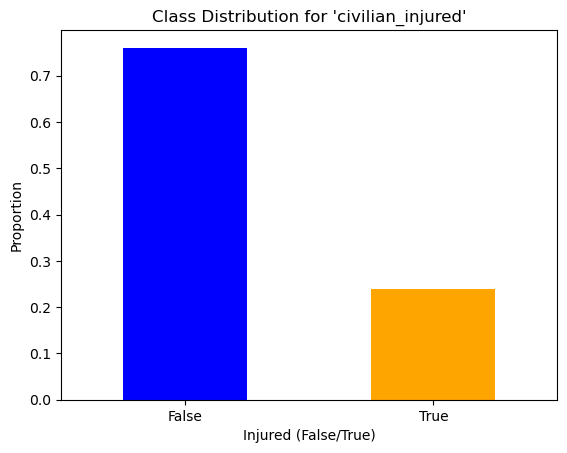

In [72]:
# istribution of the 'civilian_injured' column
class_distribution = force_deduplicated_cleaned['civilian_injured'].value_counts(normalize=True)

# Print the distribution as proportions
print("Class distribution for 'civilian_injured':")
print(class_distribution)

#visualize the distribution with a bar plot

# Bar plot to visualize the distribution
class_distribution.plot(kind='bar', color=['blue', 'orange'])
plt.title("Class Distribution for 'civilian_injured'")
plt.xlabel("Injured (False/True)")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.show()

In [75]:
# Check the shape of the cleaned dataset to ensure rows were dropped
print("Final dataset shape:", force_deduplicated_cleaned.shape)

Final dataset shape: (76698, 22)


## Step 10: Export the cleaned use of force data frame

In [80]:
# Save to a parquet file
force_deduplicated_cleaned.to_parquet('force_clean_updated.parquet', engine='pyarrow')

In [81]:
# Convert the 'dt' column to datetime if it's not already in that format
force_deduplicated_cleaned['dt'] = pd.to_datetime(force_deduplicated_cleaned['dt'], errors='coerce')

# Extract the year from the 'dt' column
force_deduplicated_cleaned['year'] = force_deduplicated_cleaned['dt'].dt.year

# Group by the 'year' column and count the number of instances of force for each year
force_per_year = force_deduplicated_cleaned.groupby('year').size().reset_index(name='force_count')

# Print the results
print(force_per_year)

    year  force_count
0   2004         4084
1   2005         5041
2   2006         4659
3   2007         4604
4   2008         5109
5   2009         5251
6   2010         5286
7   2011         5359
8   2012         5400
9   2013         5295
10  2014         5354
11  2015         5147
12  2016         4396
13  2017         4117
14  2018         3158
15  2019         3232
16  2020         1206
